# Задание 2: визуализация ациклических орграфов 

На входе алгоритма ациклический орграф и, опционально, число W (максимально допустимая ширина слоя). 

Требуется при наличествующем W реализовать распределение по слоям с помощью алгоритма Грэхема—Коффмана. При отсутствующем W нужно реализовать алгоритм минимизации количества dummy-вершин. 

После укладки по слоям требуется добавить нужно число dummy-вершин и минимизировать (эвристическими средствами) количество пересечений рёбер, идущих между соседними слоями. 

In [1]:
!pip install cvxpy

In [2]:
import os
import numpy as np
import networkx as nx
import cvxpy as cp
import itertools

import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
%matplotlib inline

### Загрузка графа

In [3]:
!git clone https://github.com/SergeyMalyshevsky/FilesForDataVisualization.git

fatal: destination path 'FilesForDataVisualization' already exists and is not an empty directory.


In [4]:
!ls FilesForDataVisualization

hw02-dag-0.graphml       hw02-dag-44n.xml         tree-60n.xml
hw02-dag-1.graphml       hw02-dag-92n.xml         tree-72n.xml
hw02-dag-13n-lection.xml tree-42n.xml             tree-84n.xml


In [5]:
def draw(graph, pos_dict, labels_dict=None, ignore_nodes_list=None,
               figsize=(12, 10), title=None, ax=None, node_size=600, **kwargs):
    draw_graph = graph.copy()
    draw_pos_dict = pos_dict.copy()
    if labels_dict is None:
        draw_labels_dict = dict(zip(list(draw_graph.nodes()), [l[1:] for l in draw_graph.nodes()]))
    else:
        draw_labels_dict = labels_dict.copy()
    if ignore_nodes_list:
        draw_graph.remove_nodes_from(ignore_nodes_list)
        for n in ignore_nodes_list:
            draw_pos_dict.pop(n, None)
            draw_labels_dict.pop(n, None)
    if figsize is not None:
        plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    nx.draw_networkx(draw_graph,
                    pos=draw_pos_dict,
                    labels=draw_labels_dict,
                    arrowsize=20,
                    node_size=node_size,
                    node_color = '#ff0',
                    node_shape='o',
                    alpha=.9,
                    linewidths=1.0,
                    width=0.75,
                    font_size=14,
                    font_color='black',
                    ax=ax,
                    **kwargs
                  )

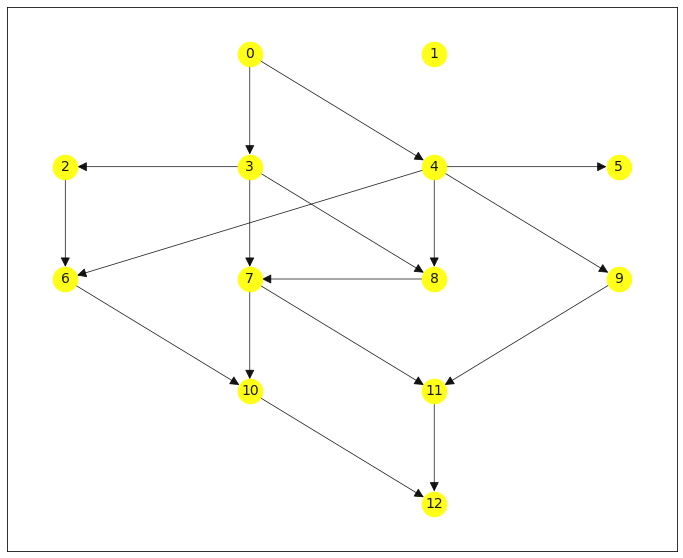

In [6]:
pos_dict = {
    'n0': (1,0), 'n1': (2,0),
    'n2': (0,-1), 'n3': (1,-1), 'n4': (2,-1), 'n5': (3,-1),
    'n6': (0,-2), 'n7': (1,-2), 'n8': (2,-2), 'n9': (3,-2),
    'n10': (1,-3), 'n11': (2,-3),
    'n12': (2,-4),
    }

graph = nx.read_graphml('FilesForDataVisualization/hw02-dag-13n-lection.xml')
am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
draw(graph, pos_dict=pos_dict)

##  Алгоритм Коффмана-Грэма (Coffman-Graham)

In [7]:
class CoffmanGraham:
    
    def get_sorted(self, seq):
        return sorted([x for x in seq], reverse=True)

    def get_sign(self, lst1, lst2):
        for i in range(max(len(lst1), len(lst2))):
            if i == len(lst1):
                return -1
            elif i == len(lst2):
                return 1
            elif lst1[i] < lst2[i]:
                return -1
            elif lst1[i] > lst2[i]:
                return 1
        return 0

    def compare(self, seq1, seq2):
        lst1 = self.get_sorted(seq1)
        lst2 = self.get_sorted(seq2)
        if (len(lst1) == 0) and (len(lst2) == 0):
            return 0
        elif len(lst1) == 0:
            return -1
        elif len(lst2) == 0:
            return 1
        else:
            return self.get_sign(lst1, lst2)

    def lexicograph_minimal_sequence(self, v2seq_dict):
        min_v = list(v2seq_dict.keys())[0]
        min_seq = v2seq_dict[min_v]
        for v, seq in v2seq_dict.items():
            if self.compare(seq, min_seq) == -1:
                min_v = v
                min_seq = seq
        return min_v, v2seq_dict.pop(min_v)

    def get_children(self, v, verts, am):
        vv = np.array(verts)
        v_id = np.argwhere(vv == v)[0][0]
        return [vv[j] for j,x in enumerate(am[v_id]) if x]

    def get_parents(self, v, verts, am):
        vv = np.array(verts)
        v_id = np.argwhere(vv == v)[0][0]
        return [vv[i] for i,x in enumerate(am[:, v_id]) if x]
    
    def get_pos_dict_from_layers(self, layers, to_shift=True):
        new_pos_dict = {}
        for level, verts in layers.items():
            for i,v in enumerate(verts):
                new_pos_dict[v] = (i+level if to_shift else i, level)
        return new_pos_dict

    def run_stage_1(self, nodes, am):
        d = {}
        for v in nodes:
            d[v] = set([np.inf]) if len(self.get_parents(v, nodes, am)) > 0 else set()
        order_d = {}
        for i in range(len(nodes)):
            min_v, min_seq = self.lexicograph_minimal_sequence(d)
            order_d[min_v] = i
            for u,j in order_d.items():
                for v in self.get_children(u, nodes, am):
                    if v in d.keys():
                        d[v].add(j)
            for u,j in order_d.items():
                for v in self.get_children(u, nodes, am):
                    if v in d.keys():
                        are_all_parents_counted = set([order_d.get(p, -1) for p in self.get_parents(v, nodes, am)]).issubset(set(d[v]))
                        if are_all_parents_counted and np.inf in d[v]:
                            d[v].remove(np.inf)
        return order_d
    
    def run_stage_2(self, nodes, am, order_d, width=np.inf):
        isolated_verts = [
            v for v in nodes
            if (len(self.get_children(v, nodes, am)) == 0) and (len(self.get_parents(v, nodes, am)) == 0)
            ]
        layers = {0: isolated_verts, 1: []}
        used = isolated_verts.copy()
        k = 1
        while set(used) != set(nodes):
            not_used = [v for v in nodes if v not in used]
            not_used_with_used_children = [v for v in not_used if set(self.get_children(v, nodes, am)).issubset(set(used))]
            v = sorted(not_used_with_used_children, key=lambda v: order_d[v])[-1]
            no_children_on_curr_level = len([u for u in self.get_children(v, nodes, am) if u in layers[k]]) == 0
            if len(layers[k]) < width and no_children_on_curr_level:
                layers[k].append(v)
            else:
                k += 1
                layers[k] = [v]
            used.append(v)
        return layers, isolated_verts

### Этап 1. Специальная топологическая сортировка вершин орграфа

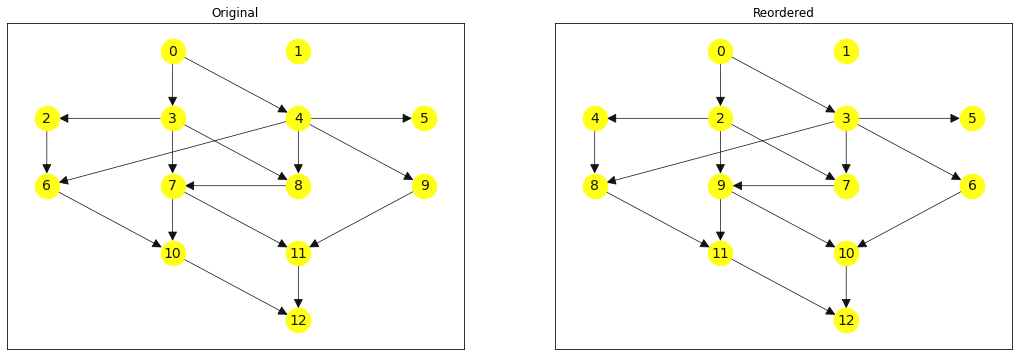

In [8]:
cg = CoffmanGraham()

am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
order_d = cg.run_stage_1(graph.nodes(), am)

fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].title.set_text('Original')
draw(graph, pos_dict=pos_dict, figsize=None, ax=axes[0])
axes[1].title.set_text('Reordered')
draw(graph, pos_dict=pos_dict, labels_dict=order_d, figsize=None, ax=axes[1])

### Этап 2. Жадное присвоение номеров слоев вершинам

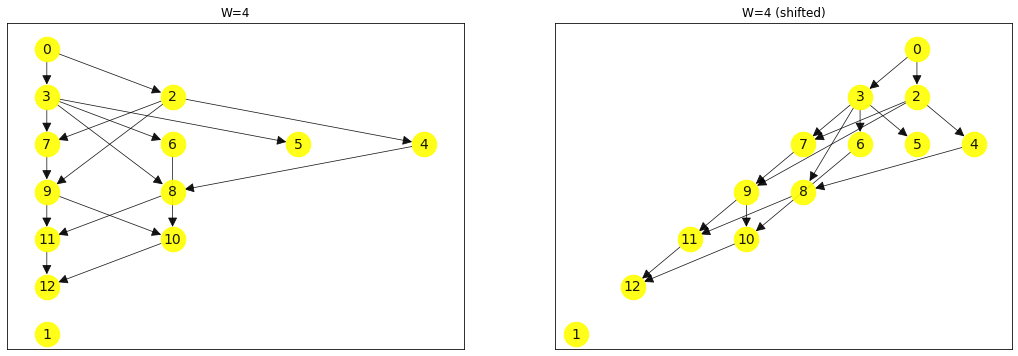

In [9]:
W = 4

am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
order_d = cg.run_stage_1(graph.nodes(), am)
layers, isolated_verts = cg.run_stage_2(graph.nodes(), am, order_d, width=W)
new_pos_dict = cg.get_pos_dict_from_layers(layers, to_shift=False)
new_pos_dict_shifted = cg.get_pos_dict_from_layers(layers)

fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].title.set_text(f'W={W}')
draw(graph, pos_dict=new_pos_dict, labels_dict=order_d,
           figsize=None, ax=axes[0])
axes[1].title.set_text(f'W={W} (shifted)')
draw(graph, pos_dict=new_pos_dict_shifted, labels_dict=order_d,
           figsize=None, ax=axes[1])

## Алгоритм минимизации количества dummy-вершин

In [10]:
def flatten_yy_on_xx(pos_dict, uncollapse=False, round=False):
    yy = set([y for x,y in pos_dict.values()])
    layers_yy2xx = dict(zip(yy, [[] for _ in range(len(yy))]))
    for v,(x,y) in pos_dict.items():
        if not uncollapse:
            layers_yy2xx[y].append(x)
        else:
            new_x = int(x) if round else x
            curr_xx = set([x for x,v in layers_yy2xx[y]])
            while new_x in curr_xx:
                new_x += 1
            layers_yy2xx[y].append((new_x,v))
    for y in layers_yy2xx.keys():
        if not uncollapse:
            layers_yy2xx[y].sort()
        else:
            layers_yy2xx[y] = sorted(layers_yy2xx[y], key=lambda x: x[0])
    return layers_yy2xx

def uncollapse_and_round(pos_dict, round=True):
    flat_dict = flatten_yy_on_xx(pos_dict, uncollapse=True, round=round)
    new_pos_dict = {}
    for y in sorted(flat_dict.keys()):
        for x,v in flat_dict[y]:
            new_pos_dict[v] = (x,y)
    return new_pos_dict

def solve_lp_on_yy(G, new_pos_dict, isolated_verts):
    G_lp = G.copy()
    G_lp.remove_nodes_from(isolated_verts)
    yy_init = np.array([new_pos_dict[v][1] for v in G_lp.nodes()])
    am_lp = nx.linalg.graphmatrix.adjacency_matrix(G_lp).toarray()
    lp_cons_3 = []
    for i in range(am_lp.shape[0]):
        for j in range(am_lp.shape[1]):
            if am_lp[i,j]:
                tmp = np.zeros((1, am_lp.shape[1]), dtype='int32')
                tmp[0, i] = 1
                tmp[0, j] = -1
                lp_cons_3.append(tmp)
    lp_cons_3 = np.vstack(lp_cons_3)
    yy = cp.Variable(am_lp.shape[0], integer=True, value=yy_init)
    objective = cp.Minimize(cp.sum_squares((am_lp - am_lp.T) @ yy))
    constraints = [1 <= yy, 1 <= (lp_cons_3 @ yy), (lp_cons_3 @ yy) <= 2]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=False, warm_start=True)
    opt_yy = yy.value
    lp_pos_dict = {}
    for i,v in enumerate(G_lp.nodes()):
        if v not in isolated_verts:
            lp_pos_dict.update({v: (new_pos_dict[v][0], round(opt_yy[i]))})
    sorted_items_by_yy = sorted(lp_pos_dict.items(), key=lambda x: x[1][1])
    if sorted_items_by_yy[-2][1][1] != sorted_items_by_yy[-1][1][1]:
        highest_v = sorted_items_by_yy[-1][0]
        prehighest_y = sorted_items_by_yy[-2][1][1]
        lp_pos_dict[highest_v] = (sorted_items_by_yy[-1][1][0], prehighest_y+1)
    lp_pos_dict = uncollapse_and_round(lp_pos_dict)
    minim_y = np.min([y for x,y in lp_pos_dict.values()])
    for i,v in enumerate(isolated_verts):
        lp_pos_dict[v] = (i, minim_y-1)
    return lp_pos_dict

def construct_dummies(G, pos_dict, order_d):
    
    def get_new_xy_on_y(y, layers_yy2xx):
        last_x = layers_yy2xx[y][-1]
        return (last_x+1, y)

    layers_yy2xx = flatten_yy_on_xx(pos_dict)
    new_order_d = order_d.copy()
    new_verts_pos_dict = {}
    new_edges = []
    replace_edges = []
    for v_from, v_to in G.edges():
        x_from, y_from = new_pos_dict[v_from]
        x_to, y_to = new_pos_dict[v_to]
        assert y_from > y_to
        dummy_yy = list(range(y_from-1, y_to, -1))
        if len(dummy_yy) > 0:
            replace_edges.append((v_from, v_to))
            vv = [get_new_xy_on_y(y, layers_yy2xx) for y in dummy_yy]
            vv_names = [f'{v_from}-{v_to}_dummy-{i}' for i in range(len(vv))]
            new_edges.append((vv_names[-1], v_to))  # add last
            prev_name = v_from
            for (new_x, new_y), new_name in zip(vv, vv_names):
                layers_yy2xx[new_y].append(new_x)
                new_verts_pos_dict[new_name] = (new_x, new_y)
                new_edges.append((prev_name, new_name))
                prev_name = new_name
    G_dummy = nx.DiGraph()
    G_dummy.add_nodes_from(G.nodes())
    G_dummy.add_nodes_from(new_verts_pos_dict.keys())
    G_dummy.add_edges_from([e for e in G.edges() if e not in replace_edges])
    G_dummy.add_edges_from(new_edges)
    new_order_d.update(dict(zip(new_verts_pos_dict.keys(), ['' for _ in range(len(new_verts_pos_dict))])))
    new_verts_pos_dict.update(pos_dict)
    return G_dummy, new_verts_pos_dict, new_order_d

def compute_cross_num(edges, pos_dict):
    def are_edges_crossed(e1, e2):
        x1_lvl1 = pos_dict[e1[0]][0]
        x2_lvl1 = pos_dict[e2[0]][0]
        x1_lvl2 = pos_dict[e1[1]][0]
        x2_lvl2 = pos_dict[e2[1]][0]
        return (x1_lvl1 < x2_lvl1) and (x1_lvl2 > x2_lvl2) \
          or (x1_lvl1 > x2_lvl1) and (x1_lvl2 < x2_lvl2)
    flat_by_yy = flatten_yy_on_xx(pos_dict, uncollapse=True)
    cnt = 0
    for y in sorted(flat_by_yy.keys())[:-1]:
        level1_vv = [v for x,v in flat_by_yy[y]]
        level2_vv = [v for x,v in flat_by_yy[y+1]]
        edgs = [e for e in edges if e[0] in level2_vv and e[1] in level1_vv]
        edgs_pairs = itertools.combinations(edgs, 2)
        for e1,e2 in edgs_pairs:
            cnt += are_edges_crossed(e1, e2)
    return cnt

In [11]:
# base stage
W = np.inf
am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
order_d = cg.run_stage_1(graph.nodes(), am)
layers, isolated_verts = cg.run_stage_2(graph.nodes(), am, order_d, width=W)
new_pos_dict = cg.get_pos_dict_from_layers(layers, to_shift=True)

# dummy stage
graph_dummy, dummy_pos_dict, dummy_order_d = construct_dummies(graph, new_pos_dict, order_d)

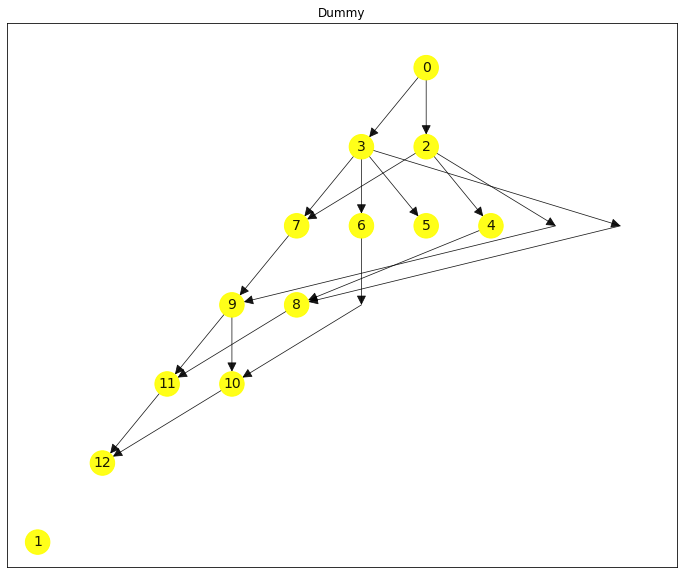

In [12]:
dummy_node_sizes = list(map(lambda n: 0 if 'dummy' in n else 600, graph_dummy.nodes()))

draw(graph_dummy, pos_dict=dummy_pos_dict, labels_dict=dummy_order_d,
           figsize=(12,10), title=f'Dummy',
           node_size=dummy_node_sizes)

In [13]:
print('|V| = {}'.format(graph_dummy.number_of_nodes()))
print('|E| = {}'.format(graph_dummy.number_of_edges()))
print('N_cross = {}'.format(compute_cross_num(graph_dummy.edges(), dummy_pos_dict)))

|V| = 16
|E| = 20
N_cross = 10


### Минимизация числа пересечений

In [14]:
def perform_one_iter_mean_shift(nodes, am, pos_dict, eps):
    flat_by_yy = flatten_yy_on_xx(pos_dict, uncollapse=True)
    mean_pos_dict = pos_dict.copy()
    for y in sorted(flat_by_yy.keys())[:-1]:
        level1 = flat_by_yy[y]
        if y == 0:
            for x,v in level1:
                mean_pos_dict[v] = (x, y)
        level2 = flat_by_yy[y+1]
        for x,v in level2:
            cg = CoffmanGraham()
            children = cg.get_children(v, nodes, am)
            mean_x = np.mean([mean_pos_dict[ch][0] for ch in children]) if len(children) else 0
            if (mean_x, y+1) in mean_pos_dict.values():
                mean_x += eps
            mean_pos_dict[v] = (mean_x, y+1)
    mean_pos_dict = uncollapse_and_round(mean_pos_dict, round=False)
    return mean_pos_dict

def perform_iterative_mean_shift(nodes, edges, am, pos_dict, eps=.5):
    it = 1
    changing = True
    prev_mean_pos_dict = perform_one_iter_mean_shift(nodes, am, pos_dict, eps)
    prev_cross_num = compute_cross_num(edges, prev_mean_pos_dict)
    while changing:
        print('[{}] N_cross = {}'.format(it, prev_cross_num))
        mean_pos_dict = perform_one_iter_mean_shift(nodes, am, prev_mean_pos_dict, eps)
        cross_num = compute_cross_num(edges, mean_pos_dict)
        changing = mean_pos_dict != prev_mean_pos_dict and cross_num <= prev_cross_num
        it += 1
        if changing:
            prev_mean_pos_dict = mean_pos_dict.copy()
            prev_cross_num = cross_num
            cross_num = compute_cross_num(edges, mean_pos_dict)
    print('[{}] N_cross = {}'.format(it, cross_num))
    return prev_mean_pos_dict

In [15]:
# base stage
W = np.inf
am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
order_d = cg.run_stage_1(graph.nodes(), am)
layers, isolated_verts = cg.run_stage_2(graph.nodes(), am, order_d, width=W)
new_pos_dict = cg.get_pos_dict_from_layers(layers, to_shift=False)

# dummy stage
graph_dummy, dummy_pos_dict, dummy_order_d = construct_dummies(graph, new_pos_dict, order_d)

# mean-dummy stage
dummy_am = nx.linalg.graphmatrix.adjacency_matrix(graph_dummy).toarray()

# two-layer-sweep iteratively while pos. dict changes
mean_dummy_pos_dict = perform_iterative_mean_shift(graph_dummy.nodes(), graph_dummy.edges(), dummy_am, dummy_pos_dict, eps=.5)

[1] N_cross = 7
[2] N_cross = 5
[3] N_cross = 4
[4] N_cross = 6


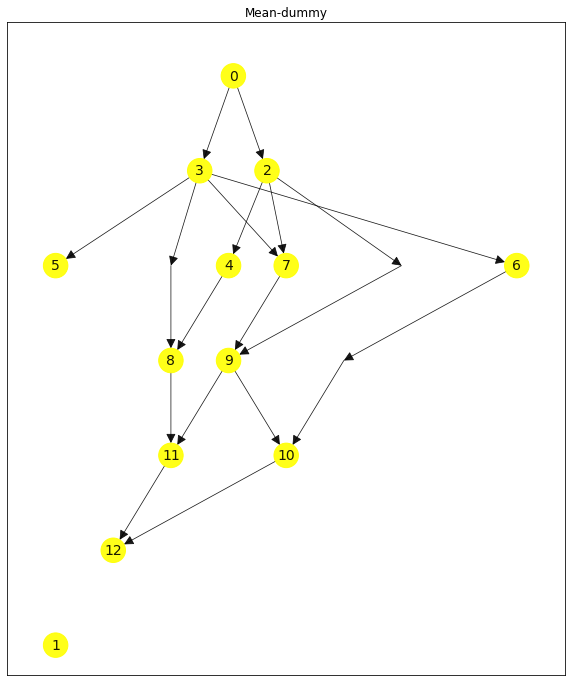

In [16]:
dummy_node_sizes = list(map(lambda n: 0 if 'dummy' in n else 600, graph_dummy.nodes()))

draw(graph_dummy, pos_dict=mean_dummy_pos_dict, labels_dict=dummy_order_d,
           figsize=(10,12), title=f'Mean-dummy',
           node_size=dummy_node_sizes)

In [17]:
print('N_cross = {}'.format(compute_cross_num(graph_dummy.edges(), mean_dummy_pos_dict)))

N_cross = 4


## Выполнение алгоритма на графах разного размера

In [18]:
graph = nx.read_graphml('FilesForDataVisualization/hw02-dag-44n.xml')

### C задаваемым значением W

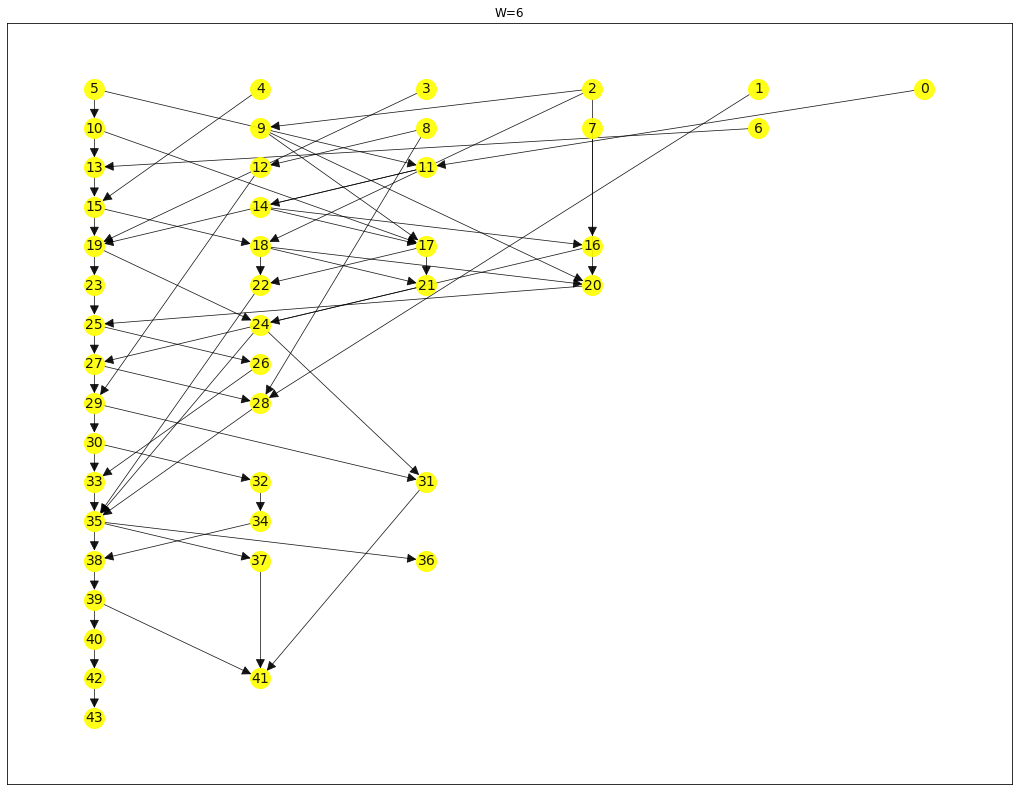

In [19]:
W = 6
am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
order_d = cg.run_stage_1(graph.nodes(), am)
layers, isolated_verts = cg.run_stage_2(graph.nodes(), am, order_d, width=W)
new_pos_dict = cg.get_pos_dict_from_layers(layers, to_shift=False)

draw(graph, pos_dict=new_pos_dict, labels_dict=order_d, #ignore_nodes_list=isolated_verts,
           figsize=(18,14), title=f'W={W}',
           node_size=400)

### Баз заданного значения W

In [20]:
W = np.inf
am = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
order_d = cg.run_stage_1(graph.nodes(), am)
layers, isolated_verts = cg.run_stage_2(graph.nodes(), am, order_d, width=W)
new_pos_dict = cg.get_pos_dict_from_layers(layers, to_shift=False)

graph_dummy, dummy_pos_dict, dummy_order_d = construct_dummies(graph, new_pos_dict, order_d)

dummy_am = nx.linalg.graphmatrix.adjacency_matrix(graph_dummy).toarray()

mean_dummy_pos_dict = perform_iterative_mean_shift(graph_dummy.nodes(), graph_dummy.edges(), dummy_am, dummy_pos_dict, eps=1.2)

[1] N_cross = 82
[2] N_cross = 85


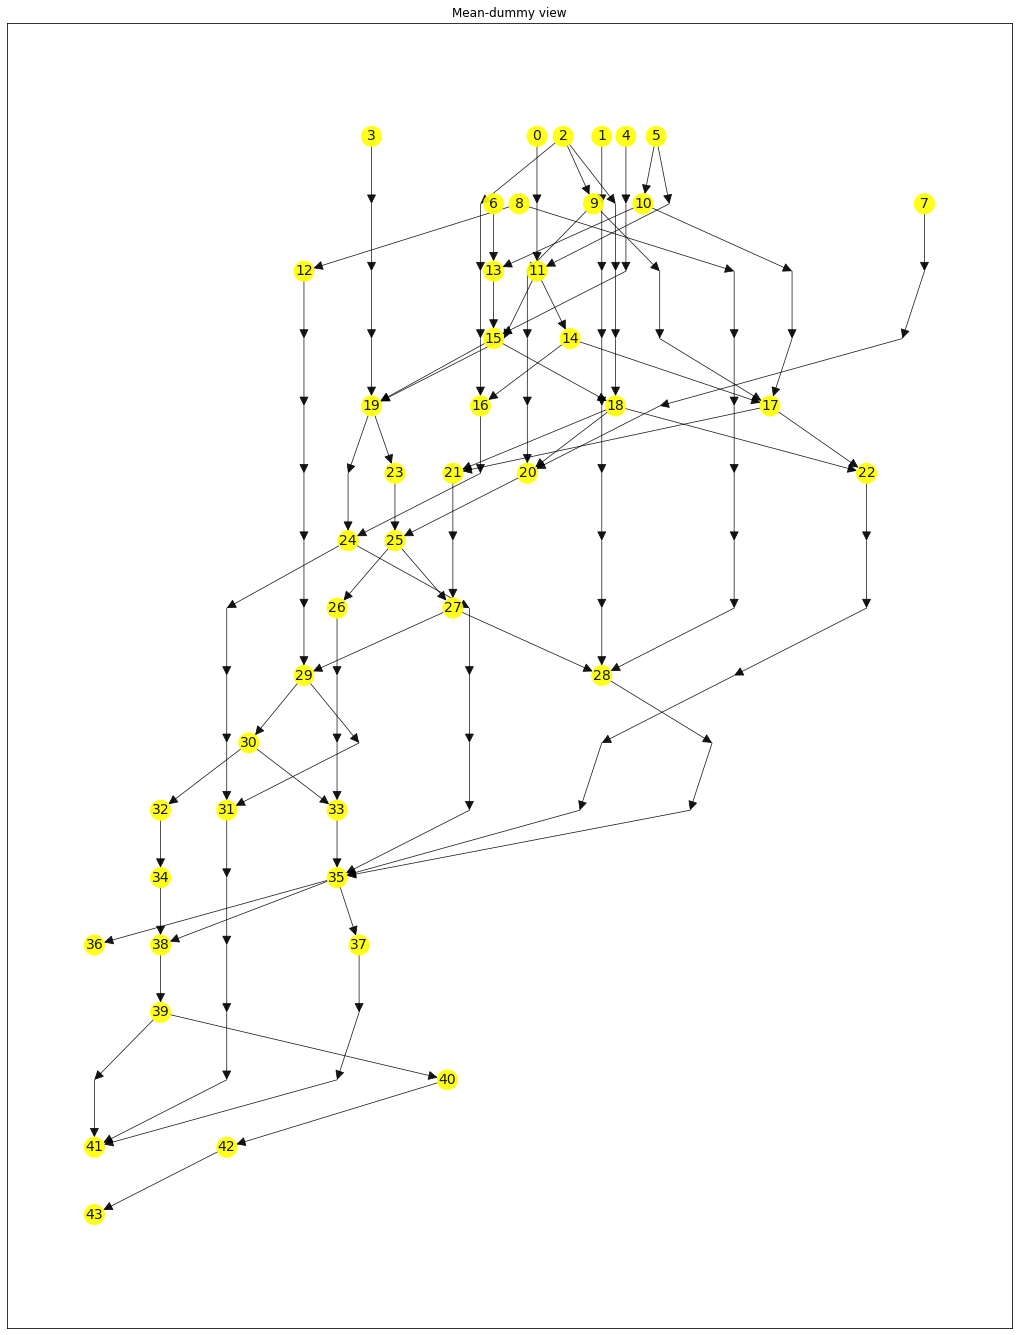

In [21]:
dummy_node_sizes = list(map(lambda n: 0 if 'dummy' in n else 400, graph_dummy.nodes()))

draw(graph_dummy, pos_dict=mean_dummy_pos_dict, labels_dict=dummy_order_d,
           figsize=(18,24), title=f'Mean-dummy view', node_size=dummy_node_sizes)